In [38]:
import os
import analysis_utils as au
import quick_metadata_plots as qmplt
import padeopsIO as pio
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
keylab = pio.budgetkey.key_labels()

from pyspod.spod.standard import Standard as spod_standard
import pyspod.spod.utils as utils_spod

import modred as mr

data_folder = "/Users/sky/src/HowlandLab/data"

In [39]:
def get_clean_data(file_name, data_folder = "/Users/sky/src/HowlandLab/data"):
    with xr.open_dataset(os.path.join(data_folder, file_name)) as ds:
        ds = ds.isel(time = slice(100, None))
    return ds

In [40]:
def plot_u(ds, t_idx):
    da = ds.u
    range_val = np.max(np.abs(1 - da))  # centered at 1
    plot_field(da.isel(time = t_idx), 1 - range_val, 1 + range_val, "Streamwise Velocity", keylab['u'])
    return 

def plot_p(ds, t_idx):
    da = ds.p
    range_val = np.max(np.abs(da))
    plot_field(da.isel(time = t_idx), -range_val, range_val, "Streamwise Pressure", keylab['p'])
    return 

def plot_vals(arr, min_val, max_val, title, label):
    plot_field(arr, min_val, max_val, title, label)
    return 

def plot_field(da, min_val, max_val, title, label):
    colormap = "bwr"
    fig, ax = plt.subplots(1, 1, dpi = 300)
    # plot velocity
    im = da.imshow(ax = ax, cmap = colormap, vmin = min_val, vmax = max_val, cbar = False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(axis='both', which='major', labelsize=12)
    cbar.set_label(label, fontsize=14)
    ax.set_title(title, size = 16)
    ax.set_xlabel(keylab['x'], size = 14)
    ax.set_ylabel(keylab['z'], size = 14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.tight_layout()
    return

In [41]:
def get_u_pod_modes(ds, num_modes, plot = True):
    return get_pod_modes(ds.u, num_modes, label = keylab['u'], plot = plot)

def get_p_pod_modes(ds, num_modes, plot = True):
    return get_pod_modes(ds.p, num_modes, label = keylab['p'], plot = plot)

def get_pod_modes(da, num_modes, label = "", avg_val = None, plot = True,):
    da = da.transpose("x", "z", "time")
    vecs = np.array(da)
    nx, nz, nt = vecs.shape
    vecs = vecs.reshape(nx * nz, nt)
    POD_res = mr.compute_POD_arrays_snaps_method(vecs, list(mr.range(num_modes)))
    modes = POD_res.modes.reshape(nx, nz, num_modes)
    eigvals = POD_res.eigvals
    if plot:
        plot_pod_modes(modes, eigvals, label, avg_val)
    return modes, eigvals

def plot_pod_modes(modes, eigvals, label, avg_val):
    nmodes = modes.shape[2]
    ncols = 2
    nrows = math.ceil(nmodes / ncols)
    fig, axes = plt.subplots(nrows, ncols, dpi = 300, figsize = (8, 4), sharex=True, sharey = True)
    if avg_val is None:
        avg_val = np.average(modes[1:5, :, :])
    range_val = np.max(np.abs(modes - avg_val))
    r, c = 0, 0
    for i in range(nmodes):
        imode = modes[:, :, i]
        iax = axes[r, c]
        im = iax.imshow(imode.transpose(), cmap='bwr', vmin = avg_val - range_val, vmax = avg_val + range_val, extent=[-5,20,-2.5,2.5])
        iax.set_title(str(round(eigvals[i])), size = 14)
        if c == 0:
            iax.set_ylabel(keylab['z'], size = 12)
        if r == nrows - 1:
            iax.set_xlabel(keylab['x'], size = 12)
        iax.tick_params(axis='both', which='major', labelsize=10)
        c += 1
        if c == ncols:
            c = 0
            r += 1
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.01, 0.25, 0.01, 0.5])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(axis='both', which='major', labelsize=12)
    cbar.set_label(label, fontsize=14)
    fig.tight_layout()

# Laminar Flow

I began by exploration with laminar flows at a medium resolution of (nx, ny, nz) = (256, 128, 128). I also started with a high amplitude and frequency of movemement with frequency $f = 1$ for all moving turbines and amplitude of $A = 0.5$ for surging turbines and $A = 5^\circ$ for pitching turbines.

## Stationary Turbine

In [42]:
stationary_ds  = get_clean_data("stationary_data_r_256_t_0.nc")

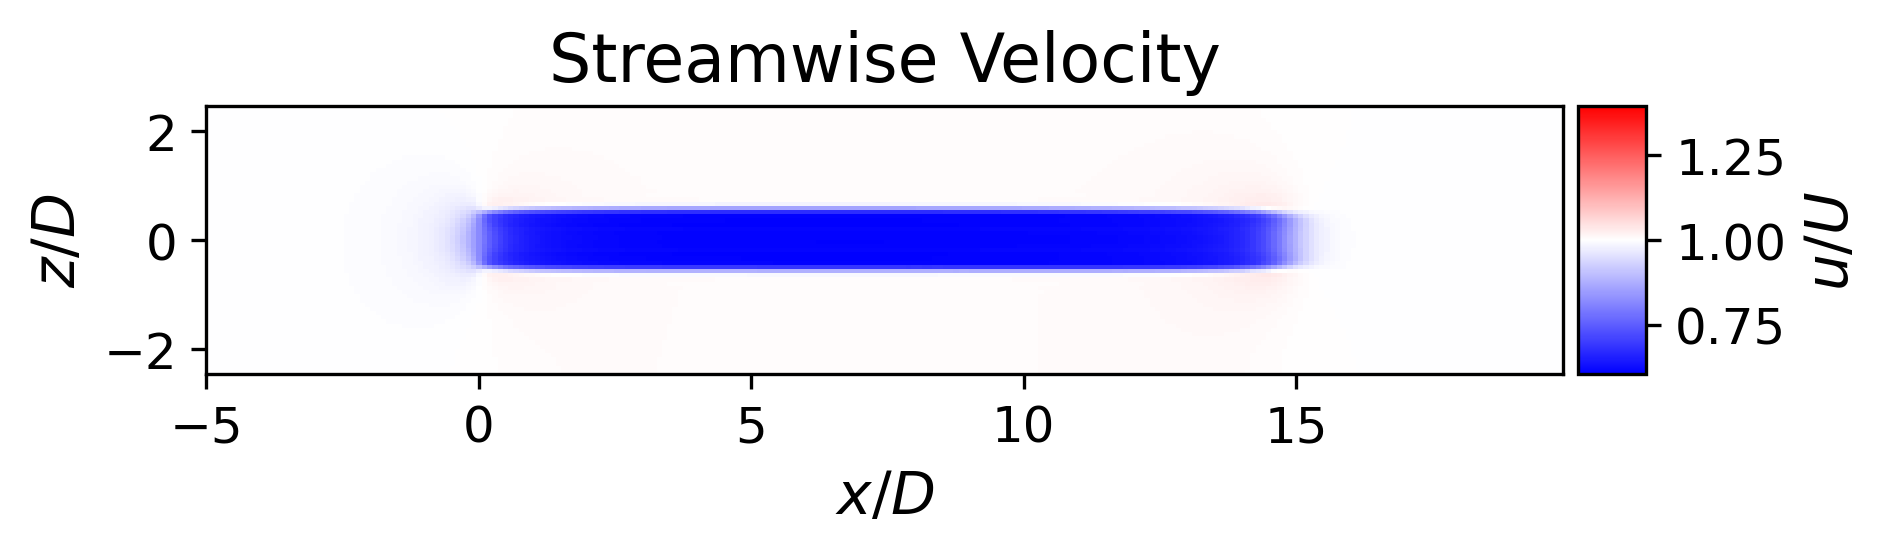

In [43]:
plot_u(stationary_ds, 1)

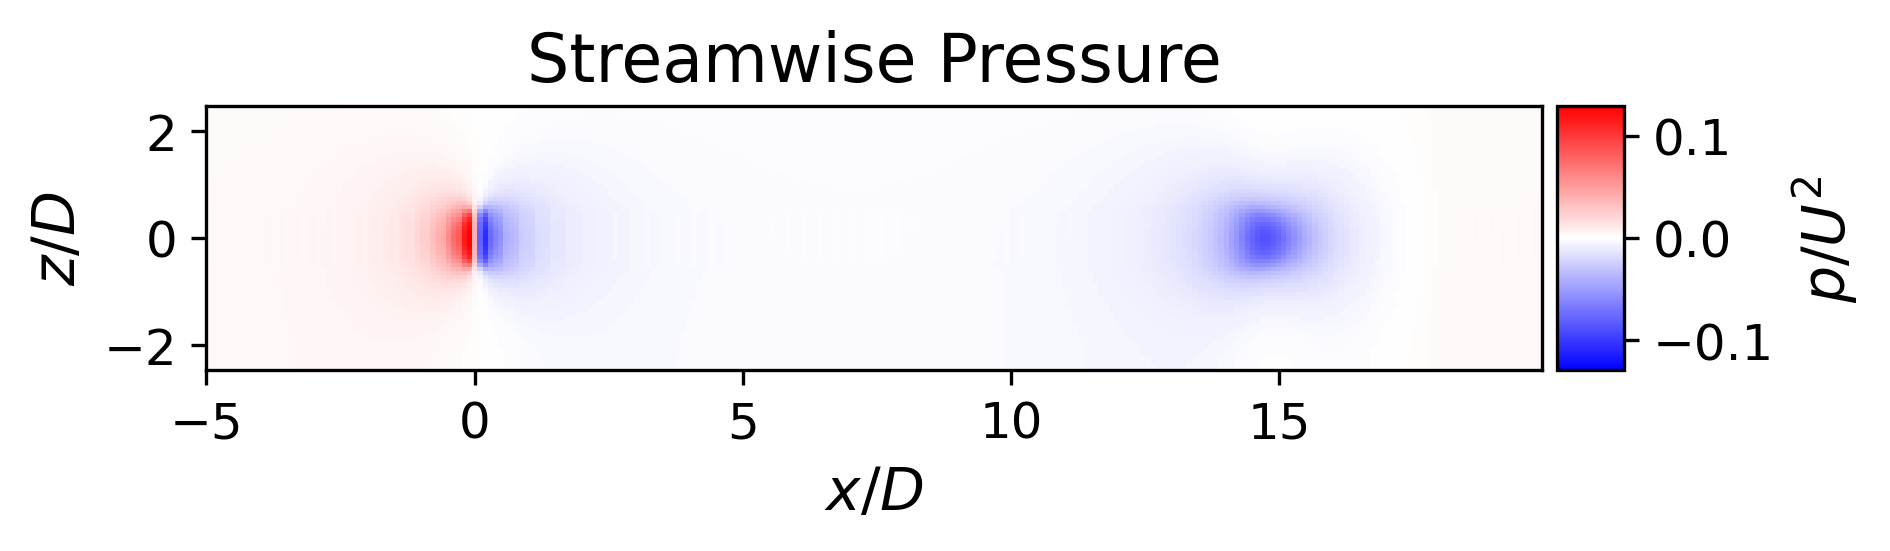

In [44]:
plot_p(stationary_ds, 1800)

## Surging Turbine

In [45]:
surging_ds  = get_clean_data("surging_data_r_256_t_0.nc")

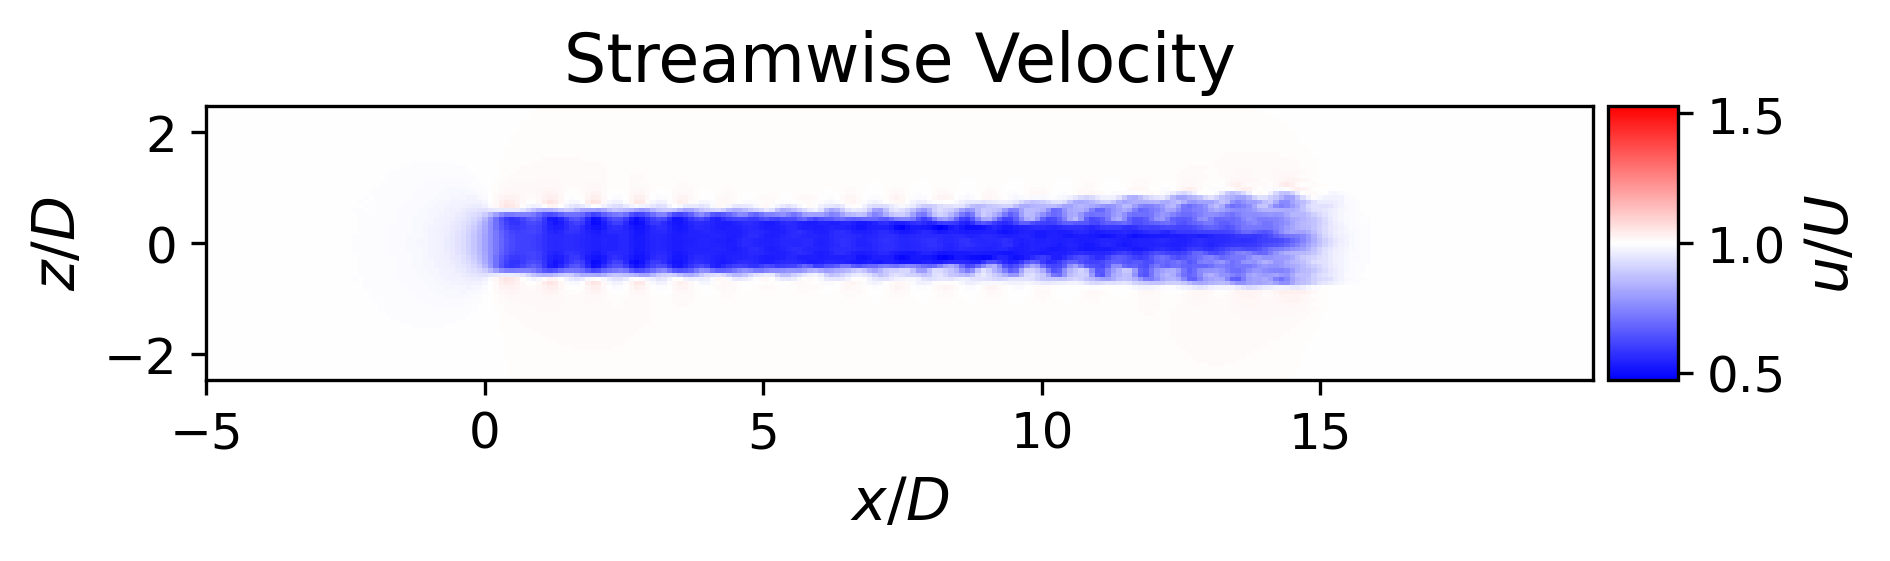

In [46]:
plot_u(surging_ds, 1800)

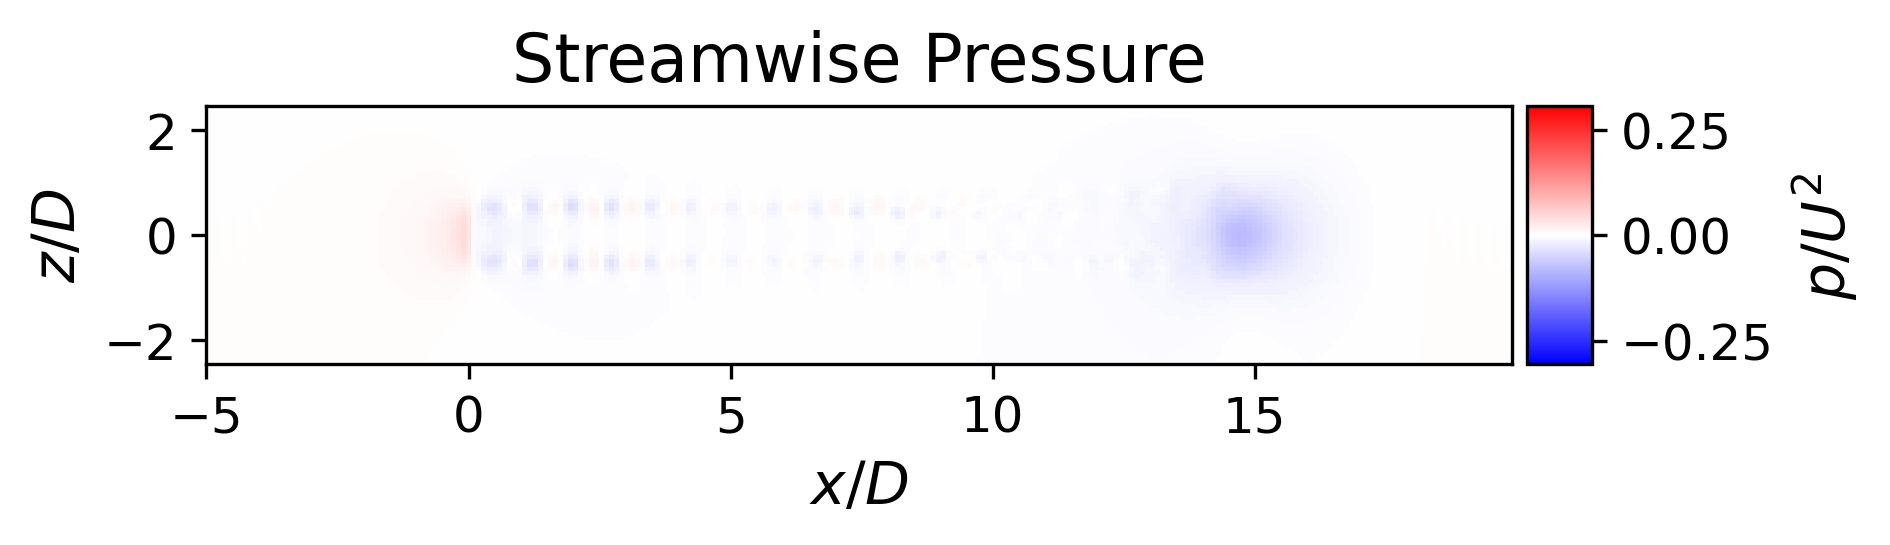

In [47]:
plot_p(surging_ds, 1800)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_37498/880678737.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


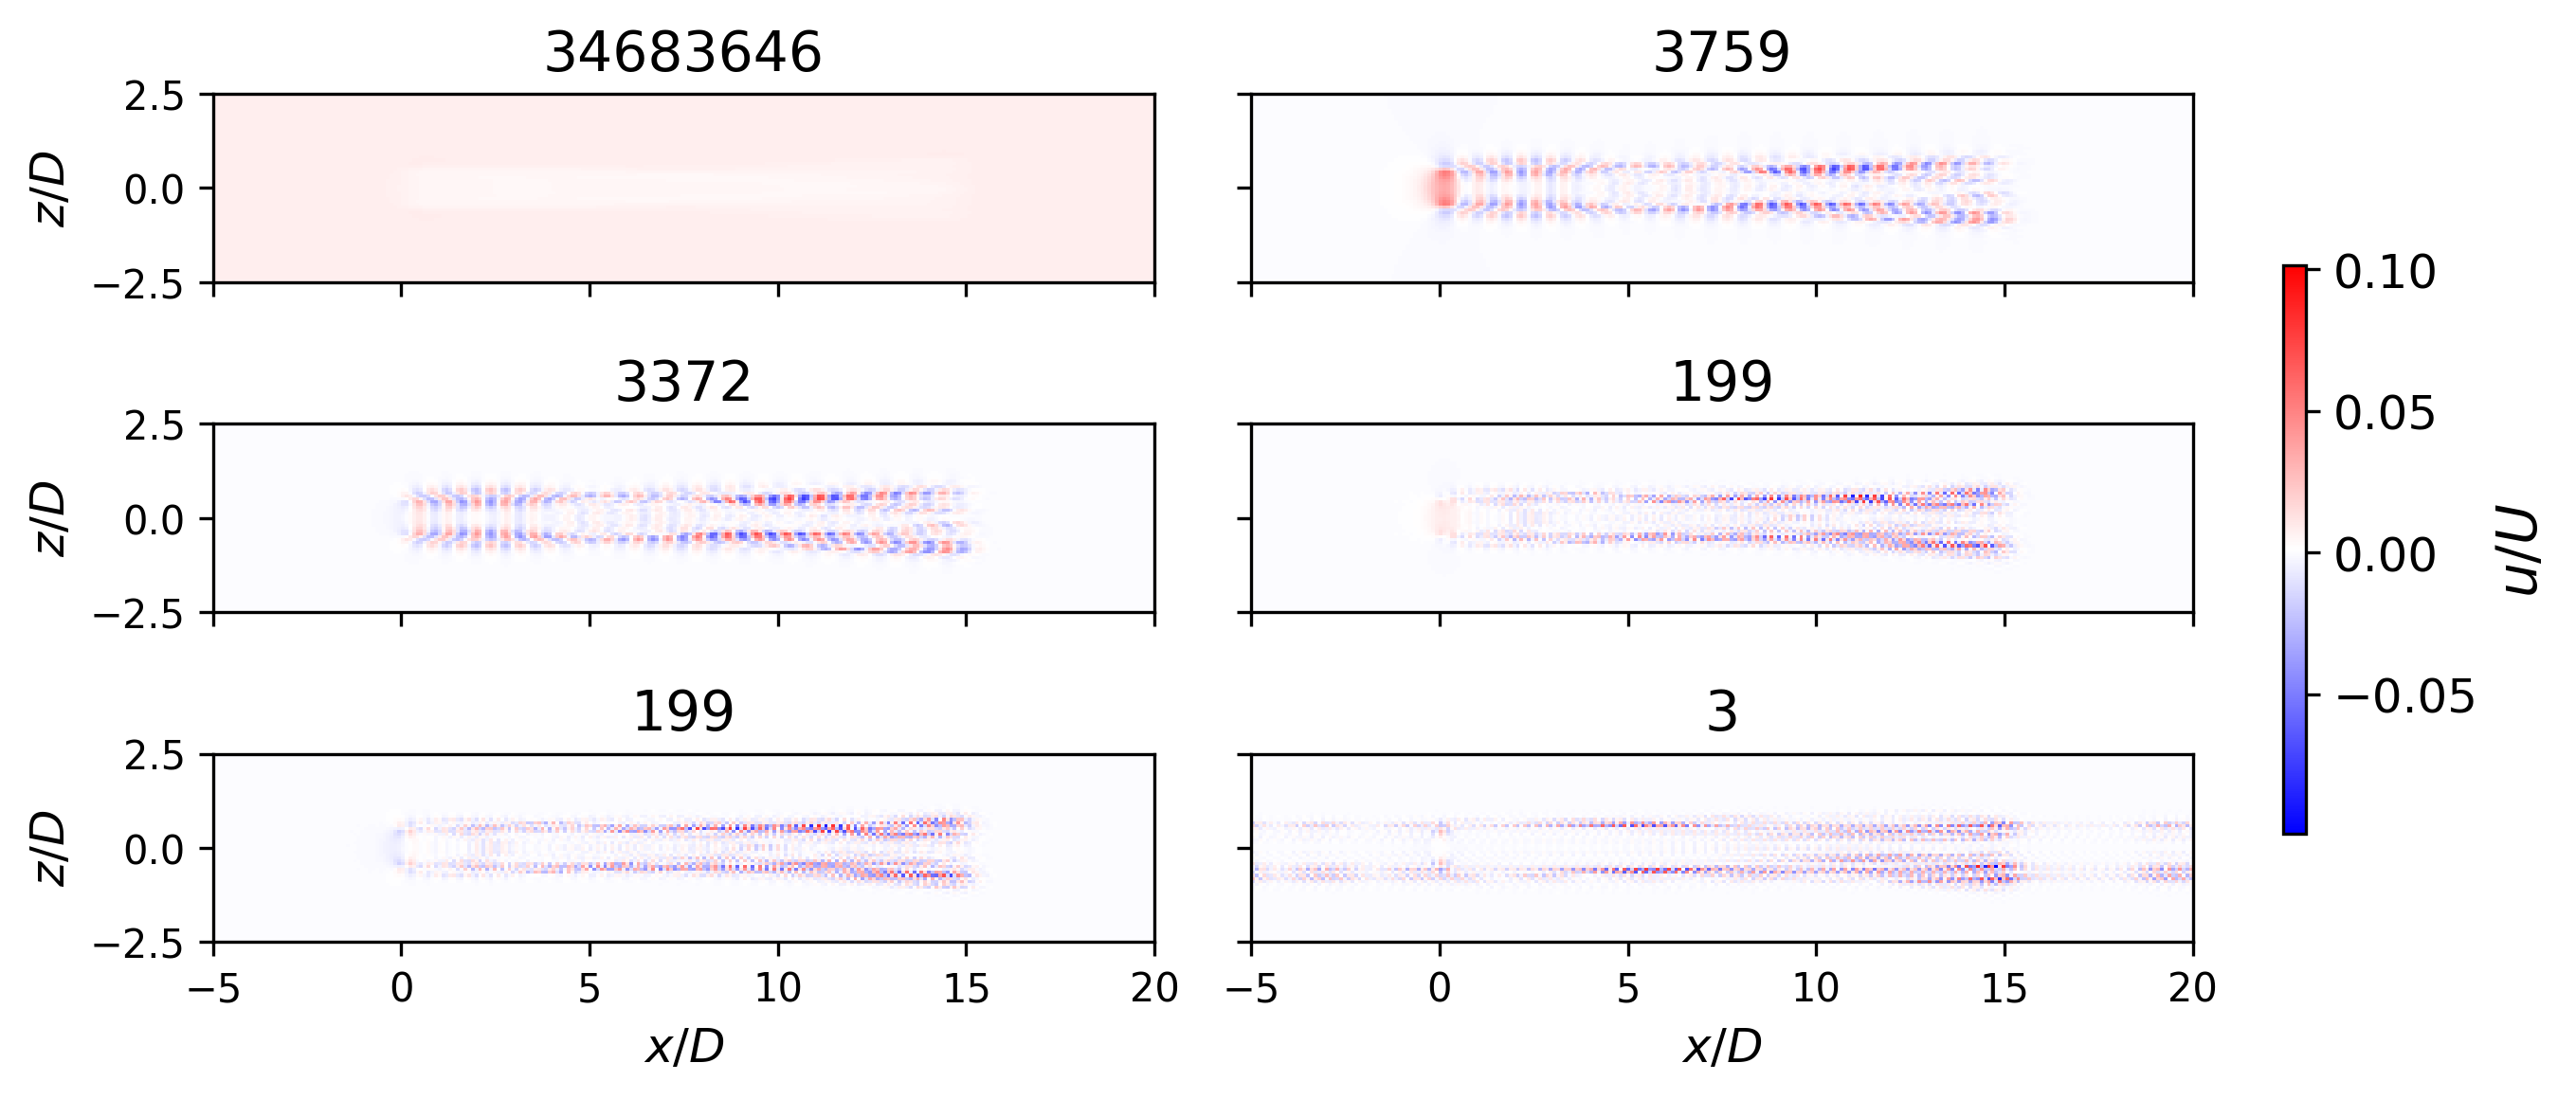

In [48]:
modes, eigenvals = get_u_pod_modes(surging_ds, 6)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_37498/880678737.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


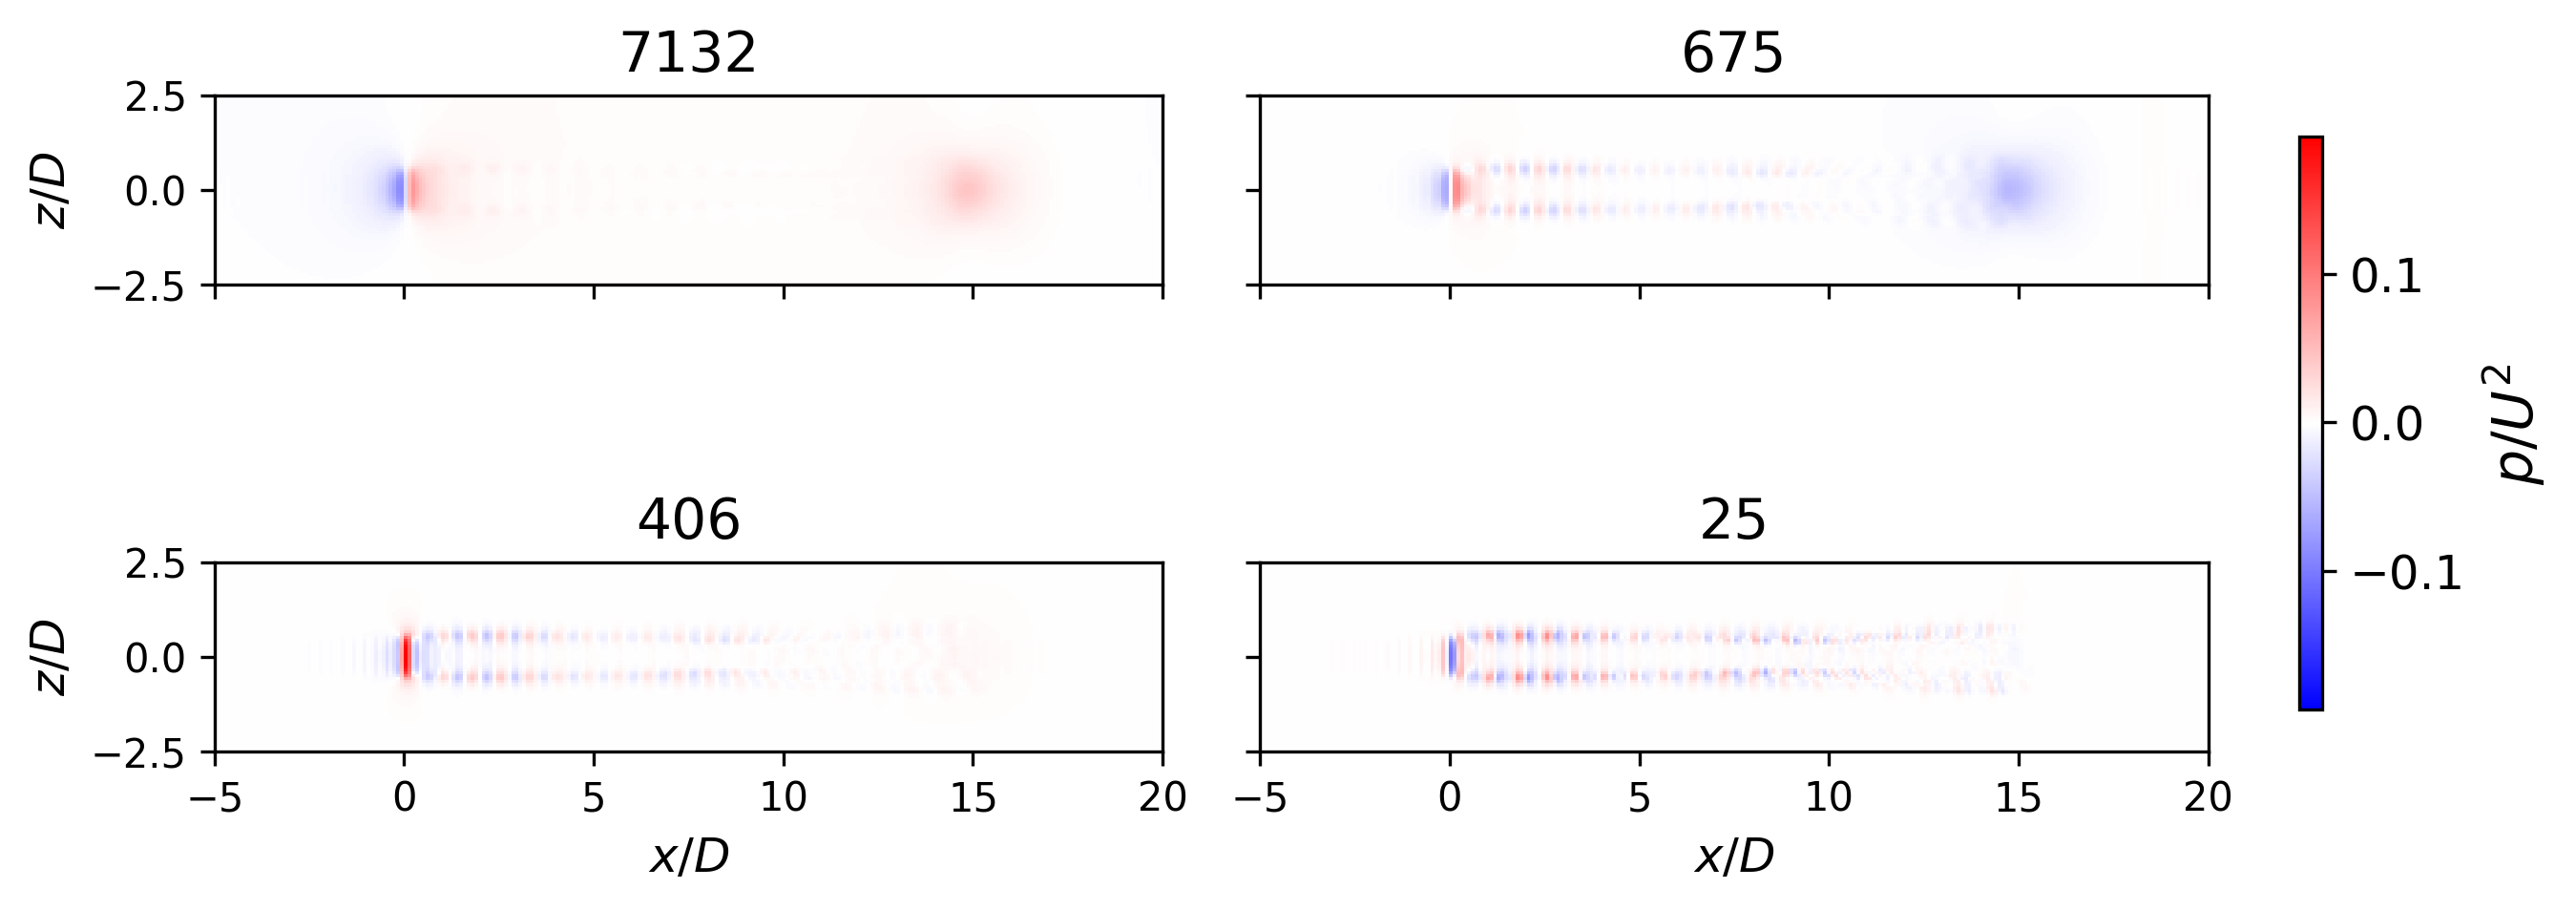

In [49]:
modes, eigs = get_p_pod_modes(surging_ds, 4)

In [50]:
params = {"time_step":0.062, "n_space_dims":2, "n_variables":1, "n_dft":50, "overlap":50, "mean_type":"longtime", "n_modes_saved":6}

In [51]:
standard  = spod_standard(params=params, comm=None)
spod = standard.fit(data_list=surging_ds.u)

 
Initialize data ...
 
Initialize data
------------------------------------
- reading first time snapshot for data dimensions
- getting data dimensions
nx: 16384
dim: 4
shape: (1, 256, 64, 1)
xdim: 2
xshape: (256, 64)
nt: 2321
- checking weight dimensions
- distributing data (if parallel)


/Library/Python/3.9/site-packages/pyspod/spod/base.py:569: UserWarning: Parameter `weights` not equal to a `numpy.ndarray`.Using default uniform weighting
  warnings.warn(


--- reading data (1 stage reader) finished in 0.22 s
- loaded data into memory: 2.1457672119140625e-06 s.
- computed mean: 0.0458531379699707 s.
SPOD parameters
------------------------------------
Problem size (real)      : 0.28 GB (min 0.28 GB/proc, max 0.28 GB/proc)
Problem size (complex)   : 0.57 GB (min 0.57 GB/proc, max 0.57 GB/proc)
Data type for real       : <class 'numpy.float64'>
Data type for complex    : <class 'numpy.complex128'>
No. snapshots per block  : 50
Block overlap            : 25
No. of blocks            : 91
Windowing fct. (time)    : hamming
Weighting fct. (space)   : uniform
Mean                     : longtime
Number of frequencies    : 26
Time-step                : 0.062
Time snapshots           : 2321
Space dimensions         : 2
Number of variables      : 1
Normalization weights    : False
Normalization data       : False
No. modes to be saved    : 91
Confidence level for eigs: 0.95
Results to be saved in   : /Users/sky/src/HowlandLab/SimsPadeOps/analysis/sp

/Library/Python/3.9/site-packages/pyspod/spod/standard.py:224: RuntimeWarning: invalid value encountered in sqrt
  L_diag = np.sqrt(self._n_blocks) * np.sqrt(L)


freq: 7/26;  (f = 1.93548);  Elapsed time: 0.03012 s.
freq: 8/26;  (f = 2.25806);  Elapsed time: 0.02995 s.
freq: 9/26;  (f = 2.58065);  Elapsed time: 0.03482 s.
freq: 10/26;  (f = 2.90323);  Elapsed time: 0.03031 s.
freq: 11/26;  (f = 3.22581);  Elapsed time: 0.03001 s.
freq: 12/26;  (f = 3.54839);  Elapsed time: 0.02917 s.
freq: 13/26;  (f = 3.87097);  Elapsed time: 0.02944 s.
freq: 14/26;  (f = 4.19355);  Elapsed time: 0.02922 s.
freq: 15/26;  (f = 4.51613);  Elapsed time: 0.02957 s.
freq: 16/26;  (f = 4.83871);  Elapsed time: 0.02918 s.
freq: 17/26;  (f = 5.16129);  Elapsed time: 0.02866 s.
freq: 18/26;  (f = 5.48387);  Elapsed time: 0.02964 s.
freq: 19/26;  (f = 5.80645);  Elapsed time: 0.03126 s.
freq: 20/26;  (f = 6.12903);  Elapsed time: 0.03204 s.
freq: 21/26;  (f = 6.45161);  Elapsed time: 0.03148 s.
freq: 22/26;  (f = 6.77419);  Elapsed time: 0.03239 s.
freq: 23/26;  (f = 7.09677);  Elapsed time: 0.03181 s.
freq: 24/26;  (f = 7.41935);  Elapsed time: 0.03108 s.
freq: 25/26; 

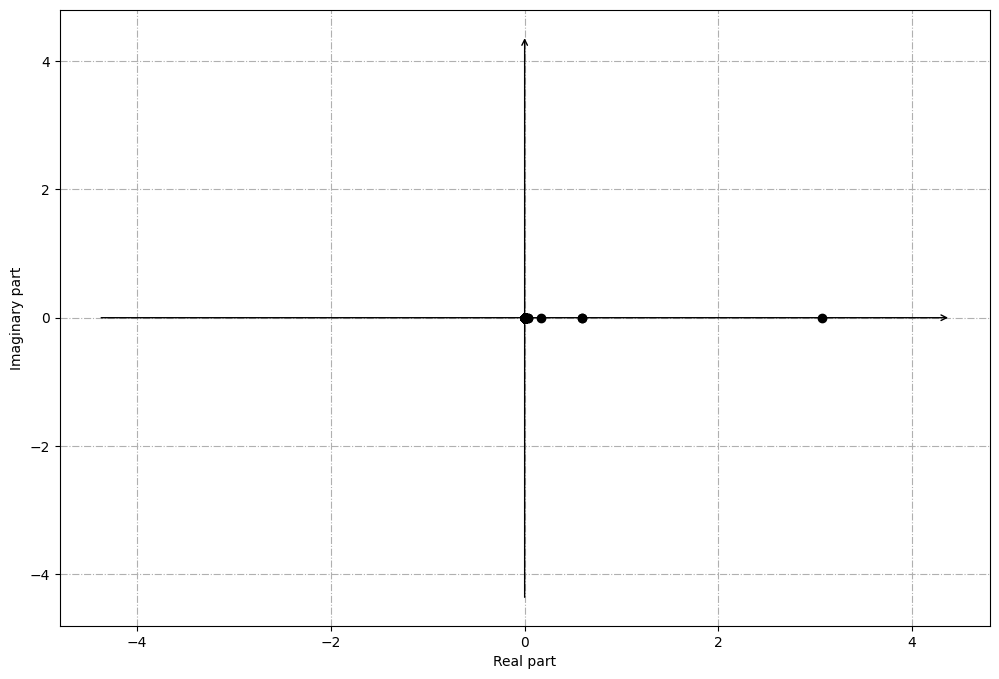

In [52]:
spod.plot_eigs()

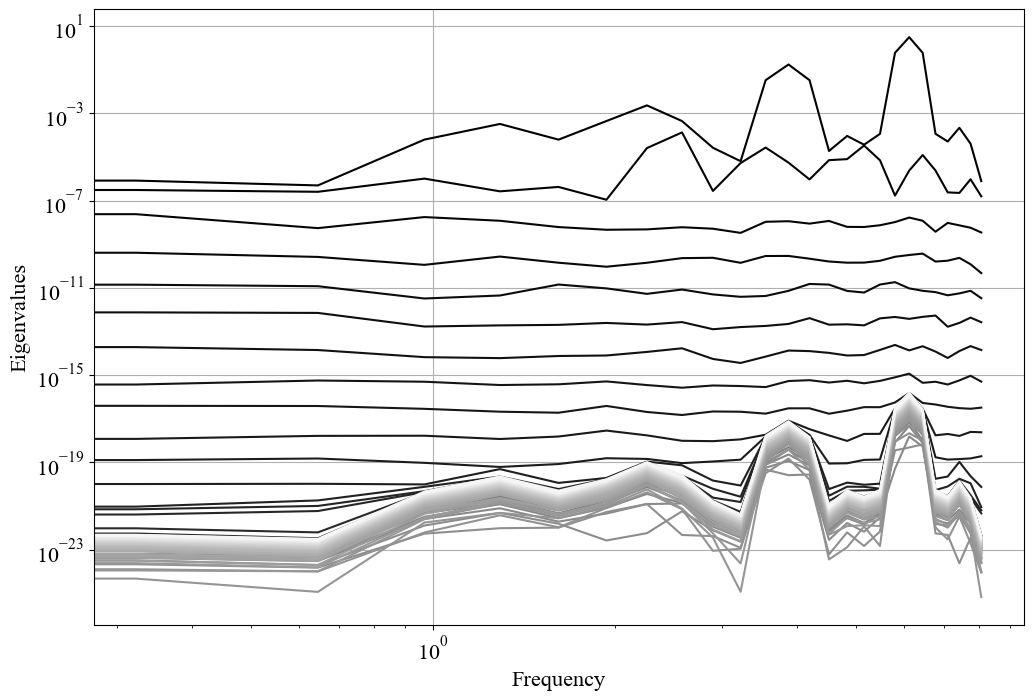

In [53]:
spod.plot_eigs_vs_frequency()

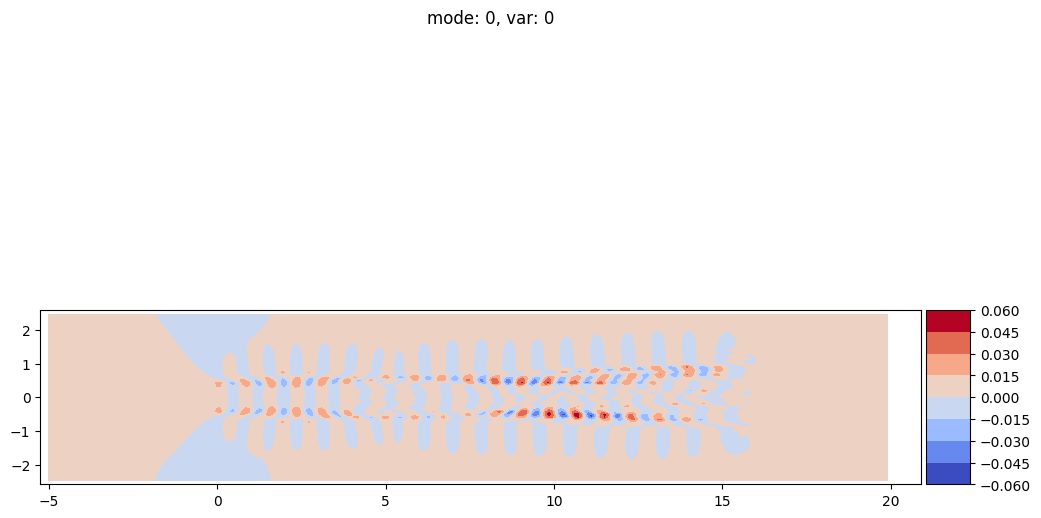

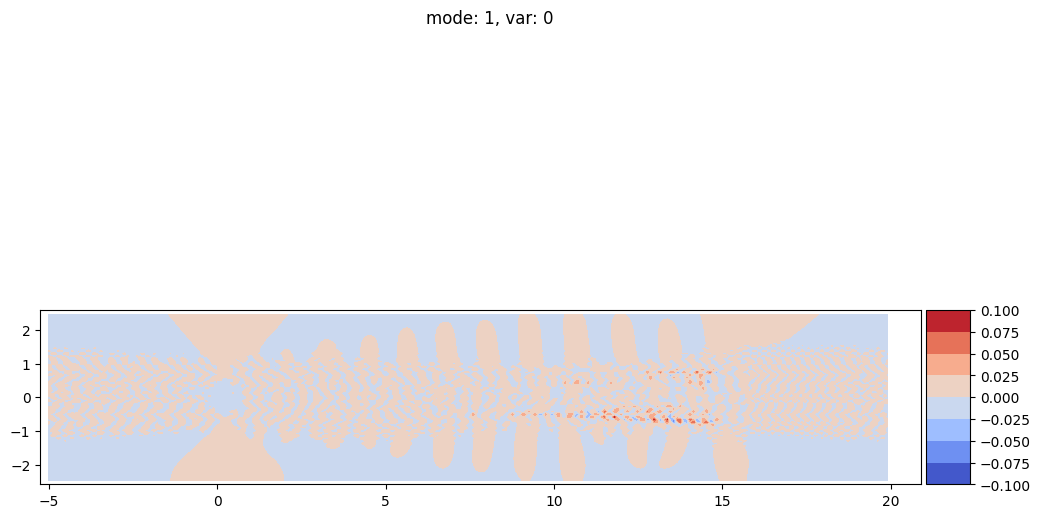

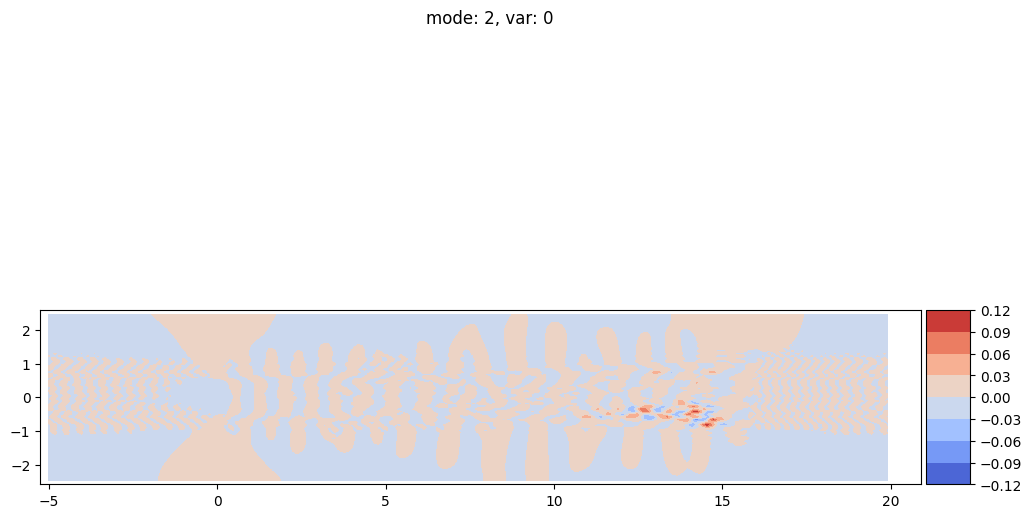

In [55]:
f1, f1_idx = spod.find_nearest_freq(freq_req=2 * math.pi, freq=spod.freq)
spod.plot_2d_modes_at_frequency(freq_req=f1, freq=spod.freq, modes_idx=[0,1,2], x1=surging_ds.x, x2=surging_ds.z, equal_axes=True)

## Pitching Turbine

In [ ]:
pitching_ds = get_clean_data("pitching_data_r_256_t_0.nc")

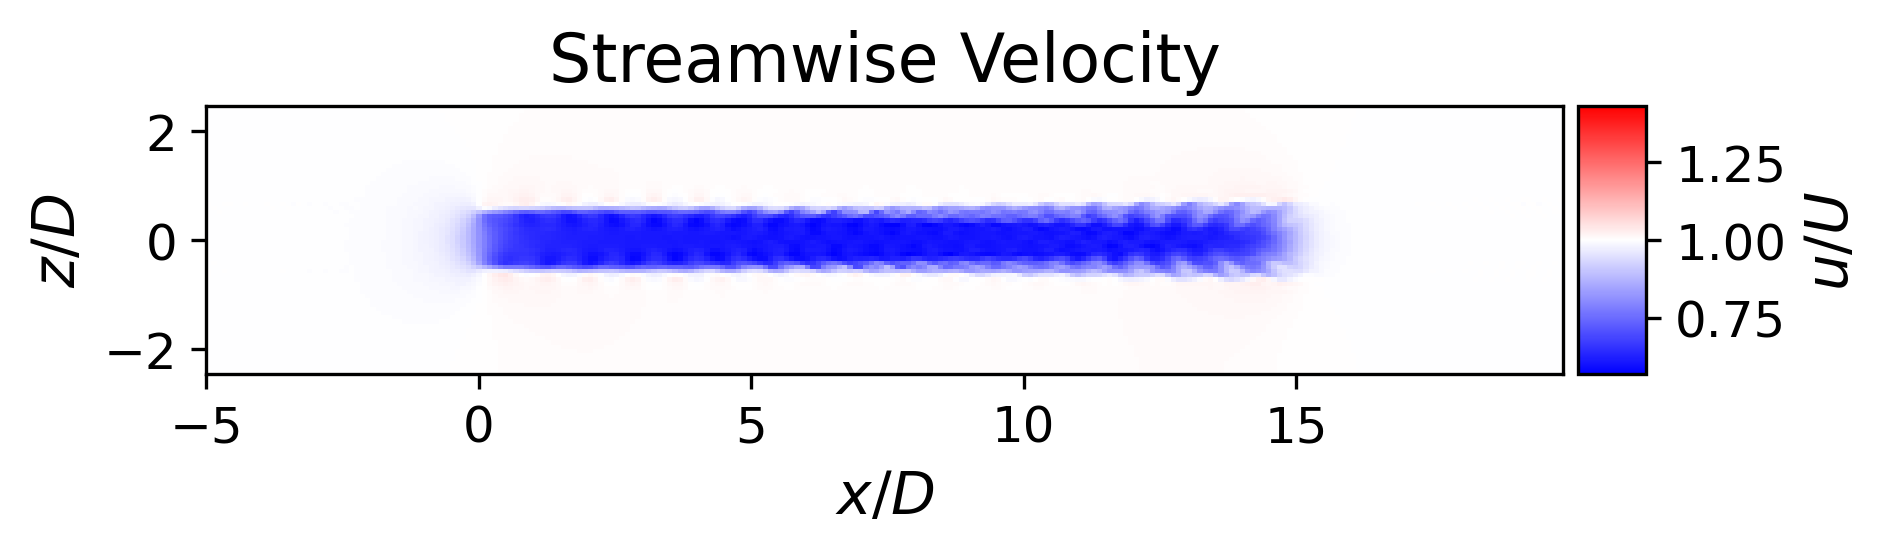

In [ ]:
plot_u(pitching_ds, 1800)

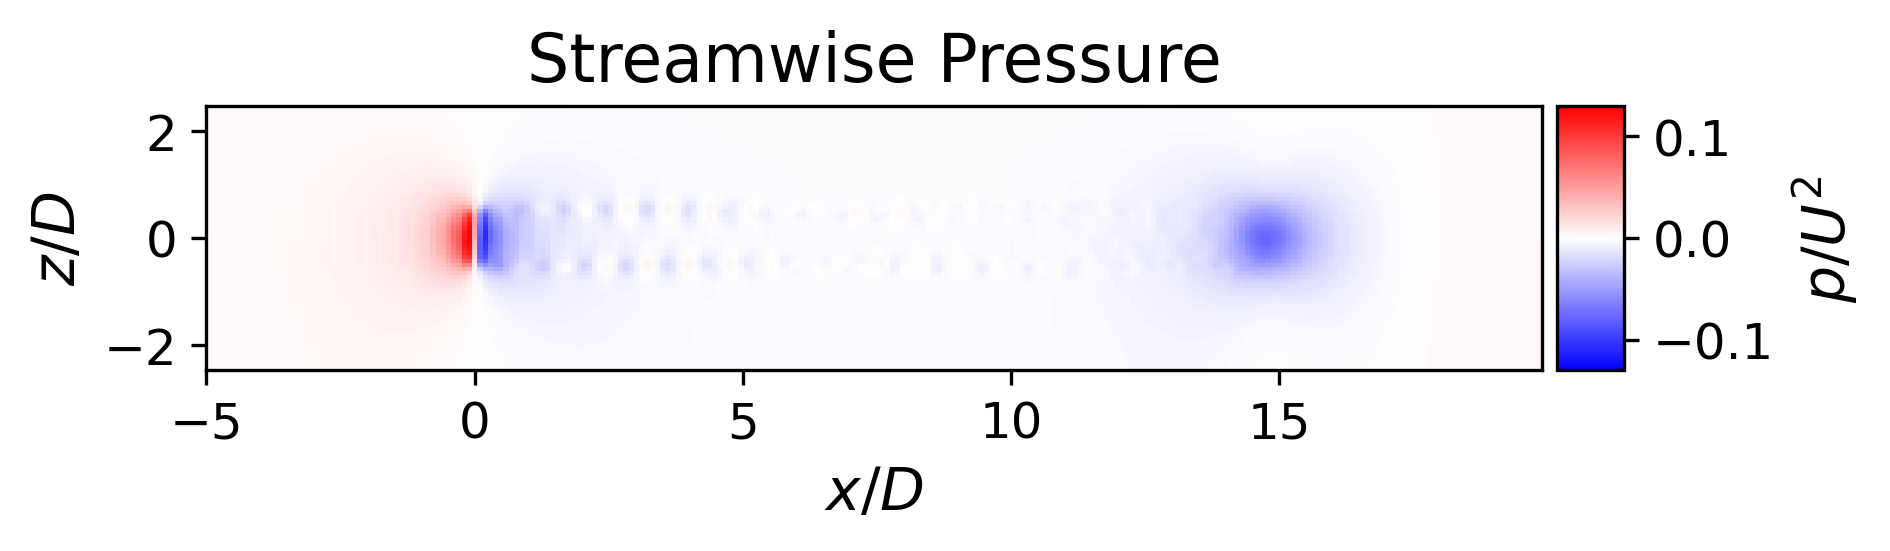

In [ ]:
plot_p(pitching_ds, 1800)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_37498/880678737.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


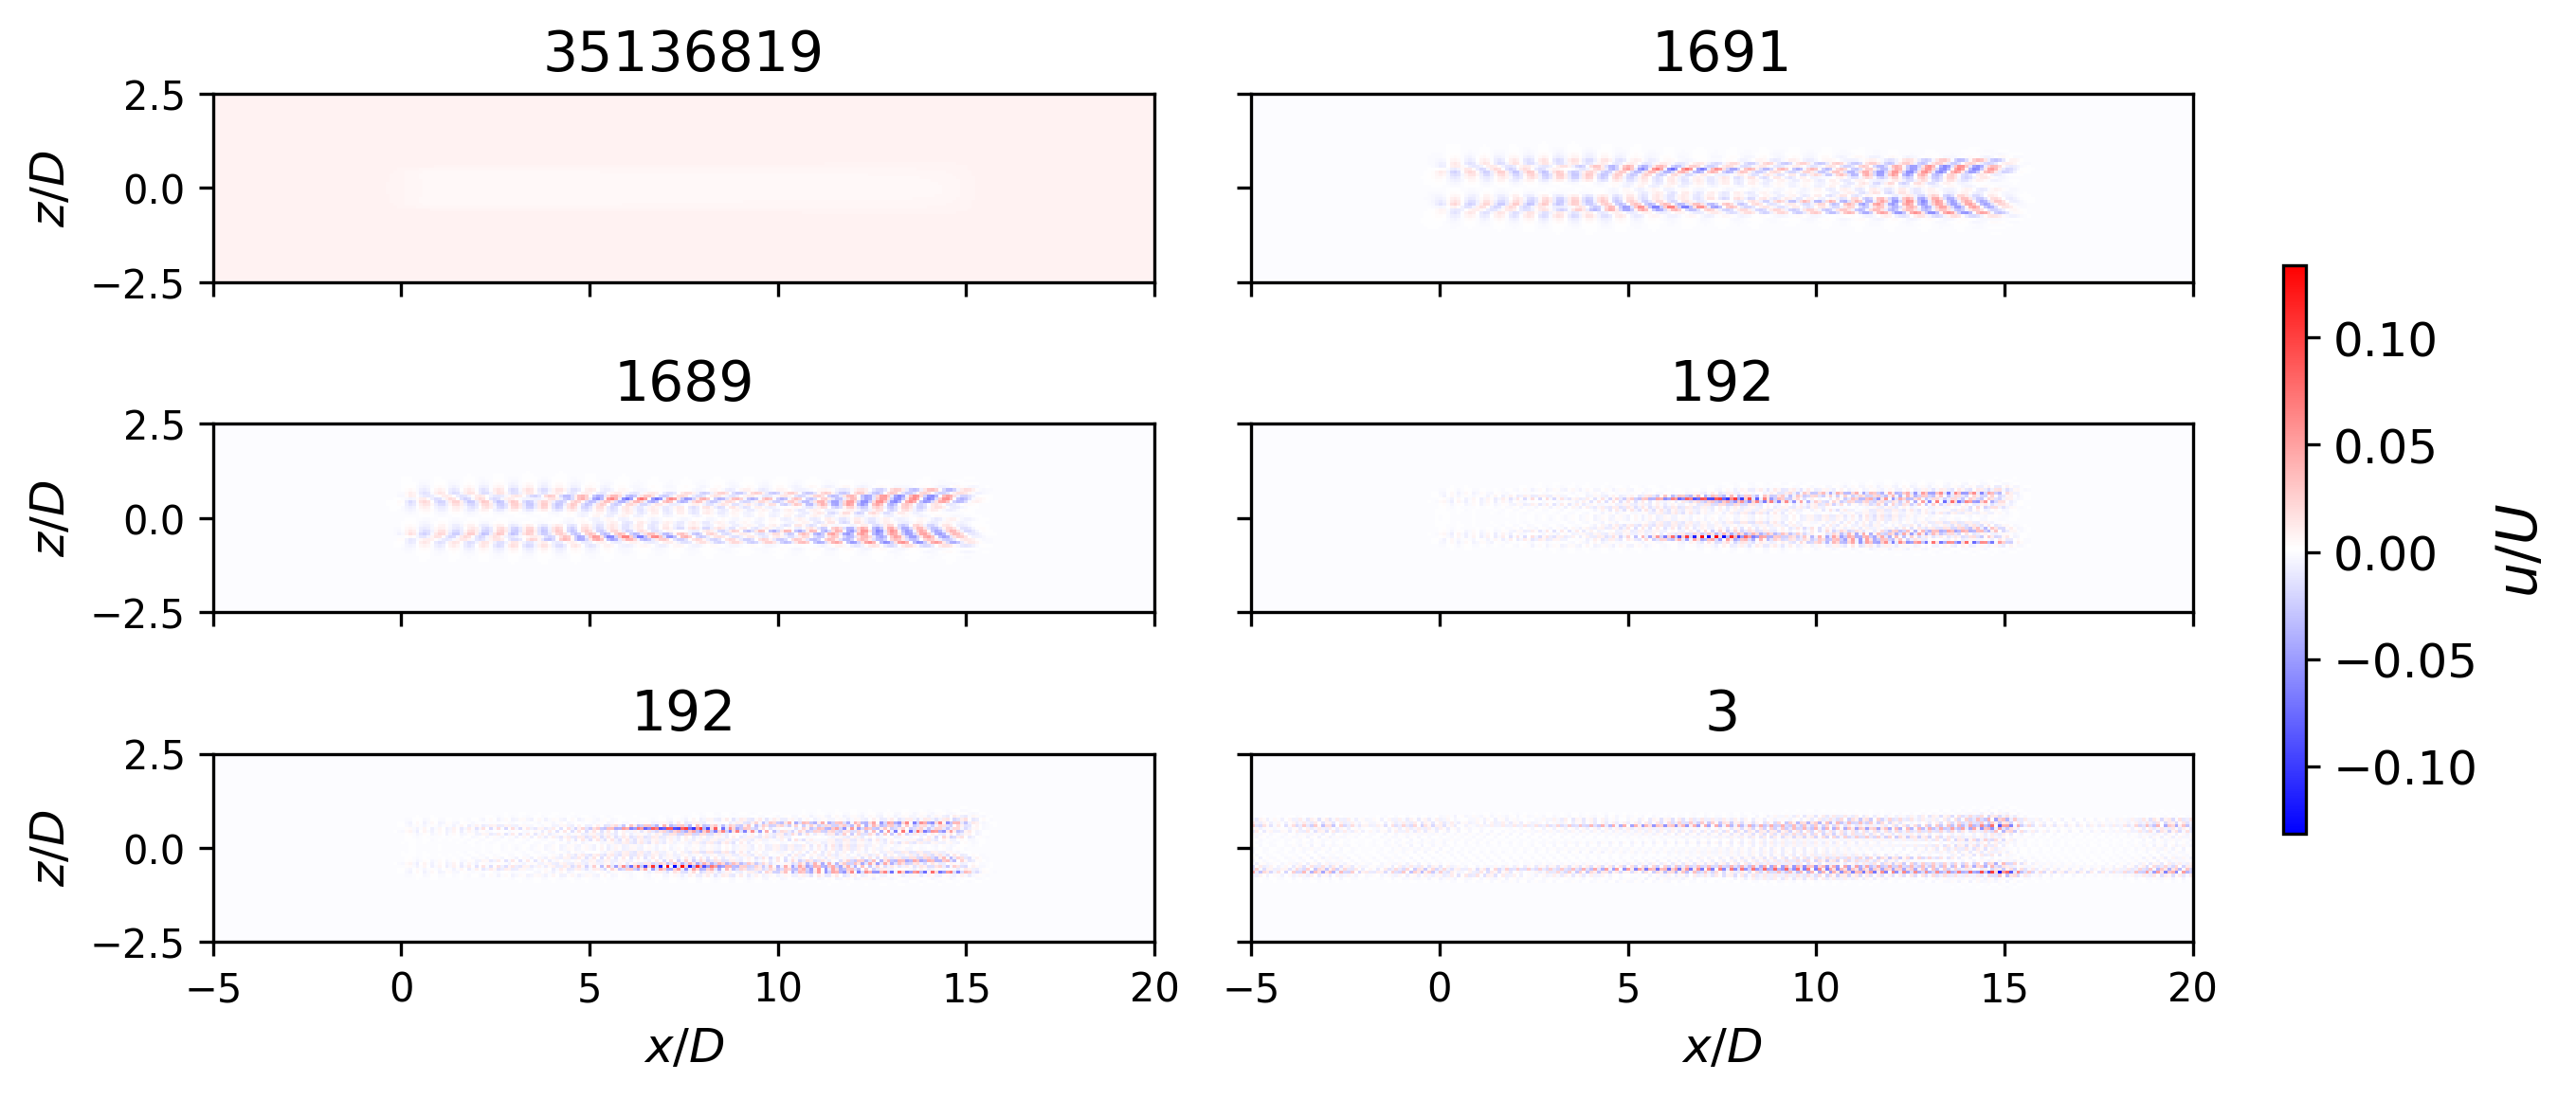

In [ ]:
modes, eigenvals = get_u_pod_modes(pitching_ds, 6)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_37498/880678737.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


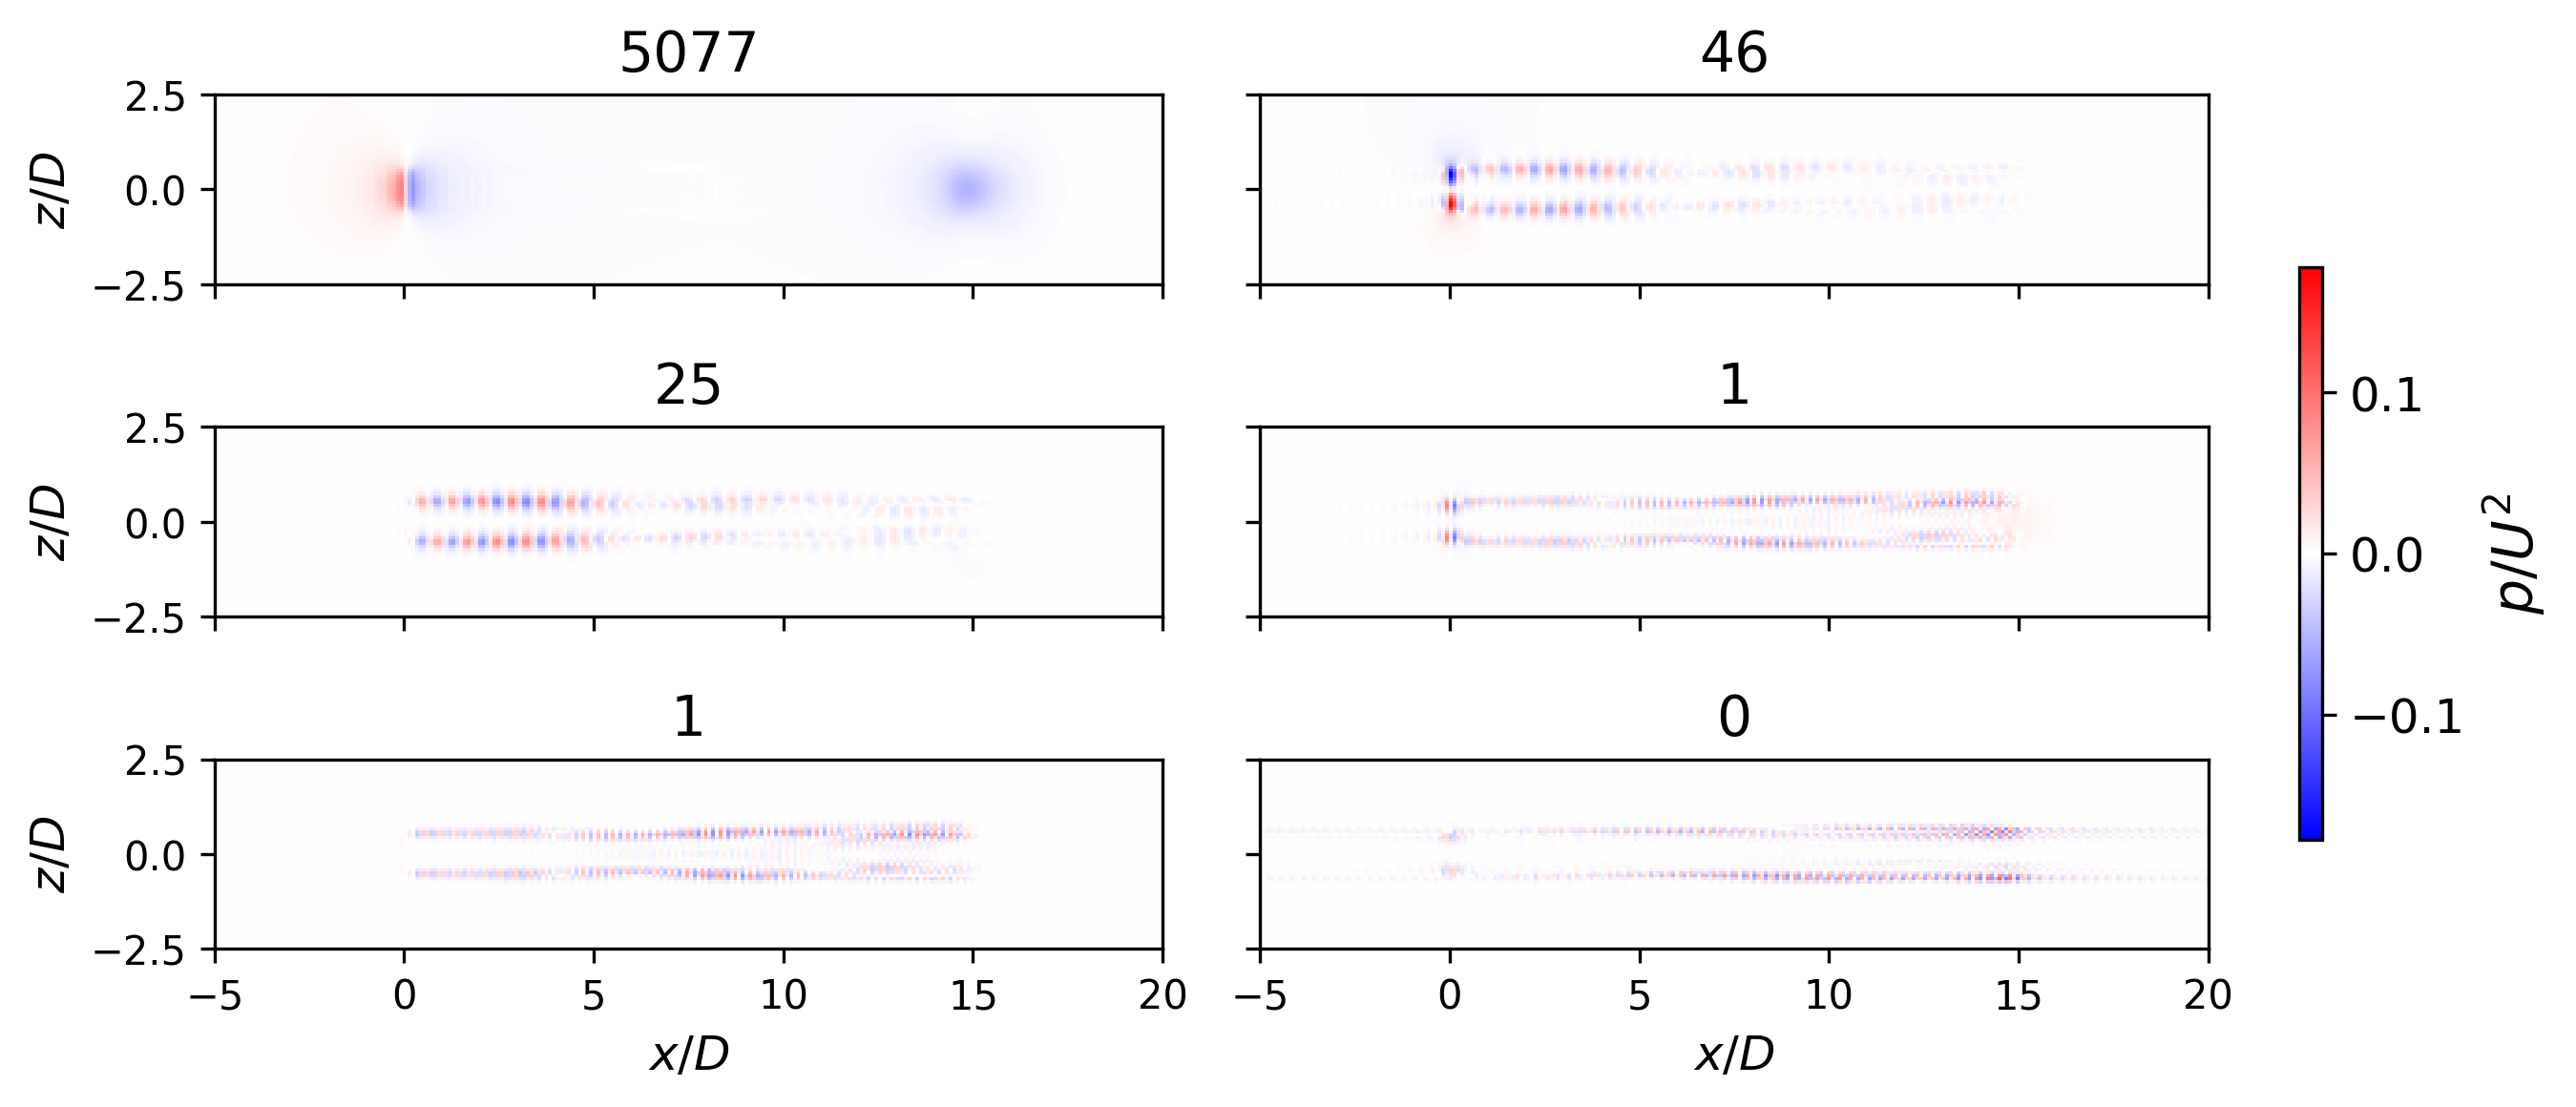

In [ ]:
modes, eigenvals = get_p_pod_modes(pitching_ds, 6)

In [ ]:
spod = standard.fit(data_list=pitching_ds.u)

 
Initialize data ...
 
Initialize data
------------------------------------
- reading first time snapshot for data dimensions
- getting data dimensions
nx: 16384
dim: 4
shape: (1, 256, 64, 1)
xdim: 2
xshape: (256, 64)
nt: 2321
- checking weight dimensions
- distributing data (if parallel)
--- reading data (1 stage reader) finished in 0.20 s
- loaded data into memory: 1.1920928955078125e-06 s.


/Library/Python/3.9/site-packages/pyspod/spod/base.py:569: UserWarning: Parameter `weights` not equal to a `numpy.ndarray`.Using default uniform weighting
  warnings.warn(


- computed mean: 0.03476977348327637 s.
SPOD parameters
------------------------------------
Problem size (real)      : 0.28 GB (min 0.28 GB/proc, max 0.28 GB/proc)
Problem size (complex)   : 0.57 GB (min 0.57 GB/proc, max 0.57 GB/proc)
Data type for real       : <class 'numpy.float64'>
Data type for complex    : <class 'numpy.complex128'>
No. snapshots per block  : 50
Block overlap            : 25
No. of blocks            : 91
Windowing fct. (time)    : hamming
Weighting fct. (space)   : uniform
Mean                     : longtime
Number of frequencies    : 26
Time-step                : 0.062
Time snapshots           : 2321
Space dimensions         : 2
Number of variables      : 1
Normalization weights    : False
Normalization data       : False
No. modes to be saved    : 91
Confidence level for eigs: 0.95
Results to be saved in   : /Users/sky/src/HowlandLab/SimsPadeOps/analysis/spod_results
Save FFT blocks          : False
Reuse FFT blocks         : False
Spectrum type: one-sided (re

/Library/Python/3.9/site-packages/pyspod/spod/standard.py:224: RuntimeWarning: invalid value encountered in sqrt
  L_diag = np.sqrt(self._n_blocks) * np.sqrt(L)


freq: 10/26;  (f = 2.90323);  Elapsed time: 0.01980 s.
freq: 11/26;  (f = 3.22581);  Elapsed time: 0.02420 s.
freq: 12/26;  (f = 3.54839);  Elapsed time: 0.02247 s.
freq: 13/26;  (f = 3.87097);  Elapsed time: 0.01874 s.
freq: 14/26;  (f = 4.19355);  Elapsed time: 0.01813 s.
freq: 15/26;  (f = 4.51613);  Elapsed time: 0.01936 s.
freq: 16/26;  (f = 4.83871);  Elapsed time: 0.02015 s.
freq: 17/26;  (f = 5.16129);  Elapsed time: 0.01912 s.
freq: 18/26;  (f = 5.48387);  Elapsed time: 0.01843 s.
freq: 19/26;  (f = 5.80645);  Elapsed time: 0.01958 s.
freq: 20/26;  (f = 6.12903);  Elapsed time: 0.01840 s.
freq: 21/26;  (f = 6.45161);  Elapsed time: 0.02013 s.
freq: 22/26;  (f = 6.77419);  Elapsed time: 0.02019 s.
freq: 23/26;  (f = 7.09677);  Elapsed time: 0.01958 s.
freq: 24/26;  (f = 7.41935);  Elapsed time: 0.02013 s.
freq: 25/26;  (f = 7.74194);  Elapsed time: 0.01920 s.
freq: 26/26;  (f = 8.06452);  Elapsed time: 0.02498 s.
Weights saved in: /Users/sky/src/HowlandLab/SimsPadeOps/analysis/

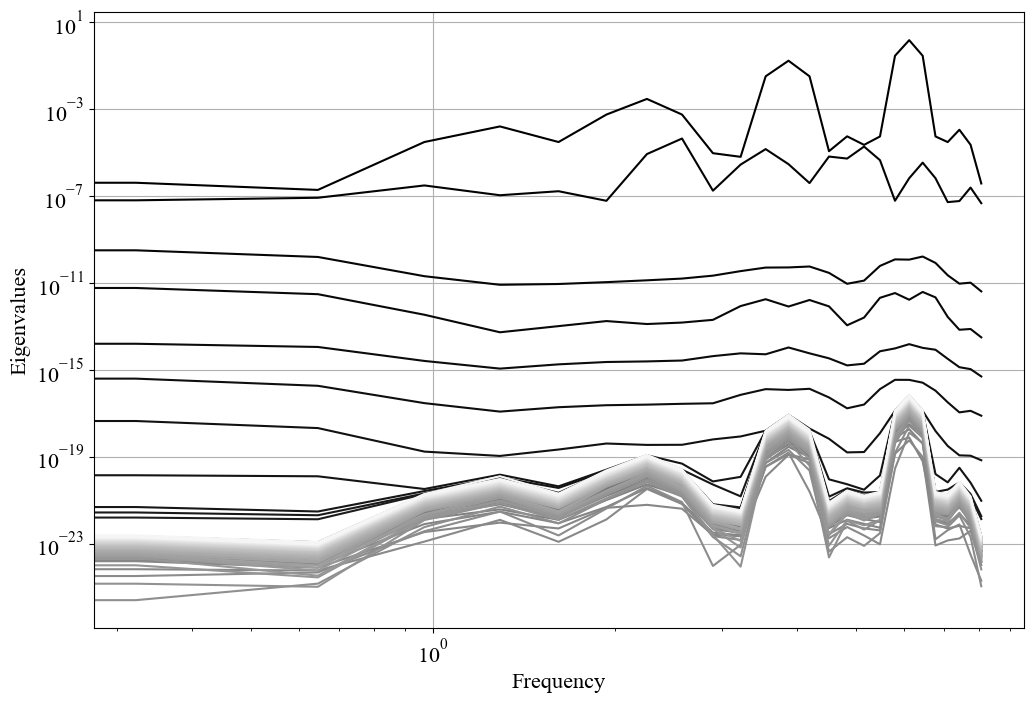

In [ ]:
spod.plot_eigs_vs_frequency()

## Surging and Pitching Turbine

In [ ]:
surging_pitching_ds = get_clean_data("surging_pitching_data_r_256_t_0.nc")

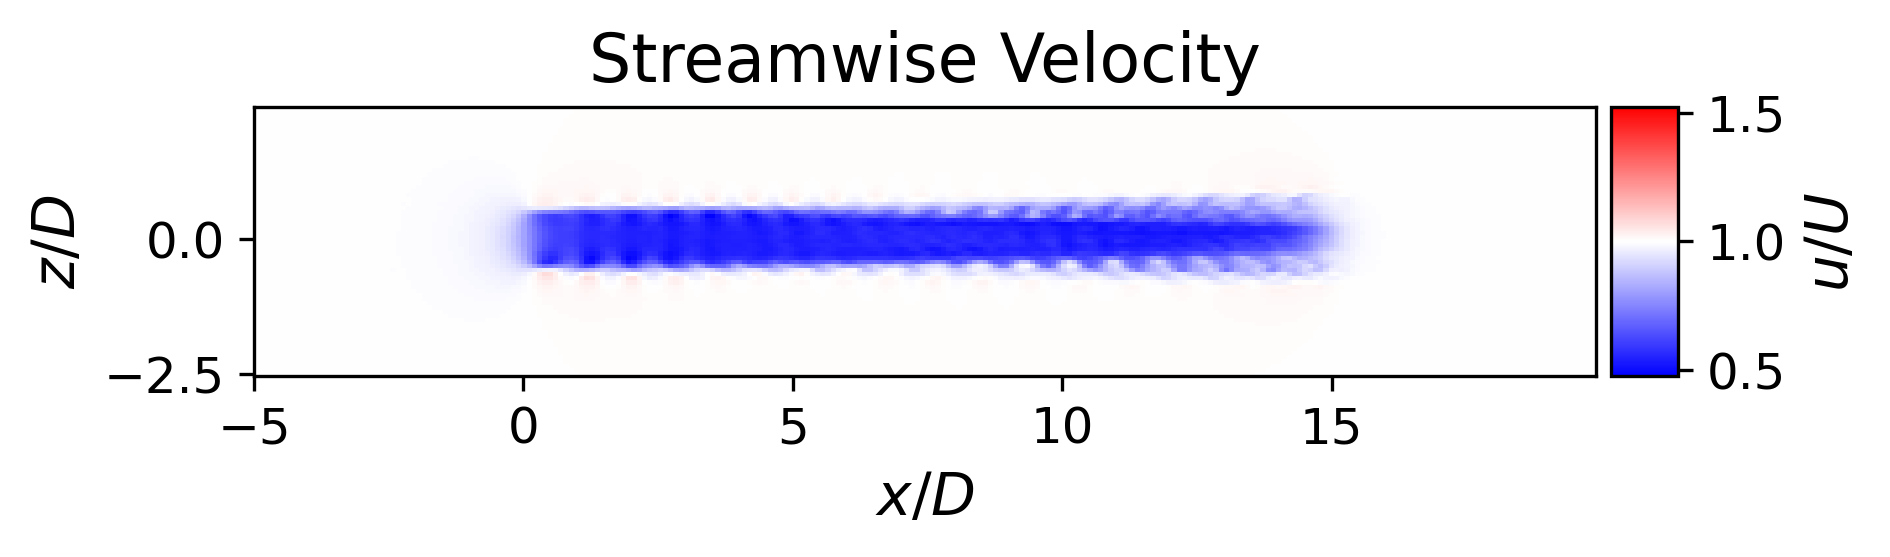

In [ ]:
plot_u(surging_pitching_ds, 1800)

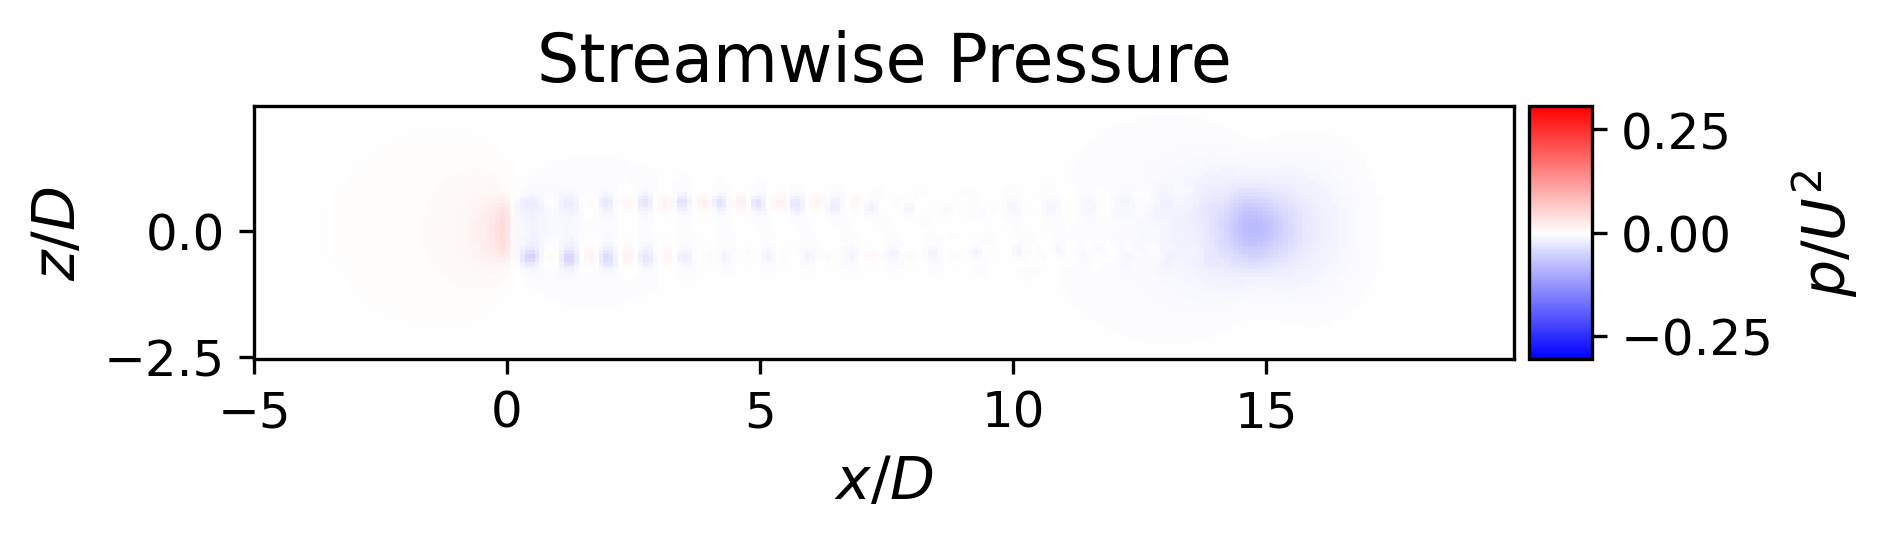

In [ ]:
plot_p(surging_pitching_ds, 1800)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_37498/880678737.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


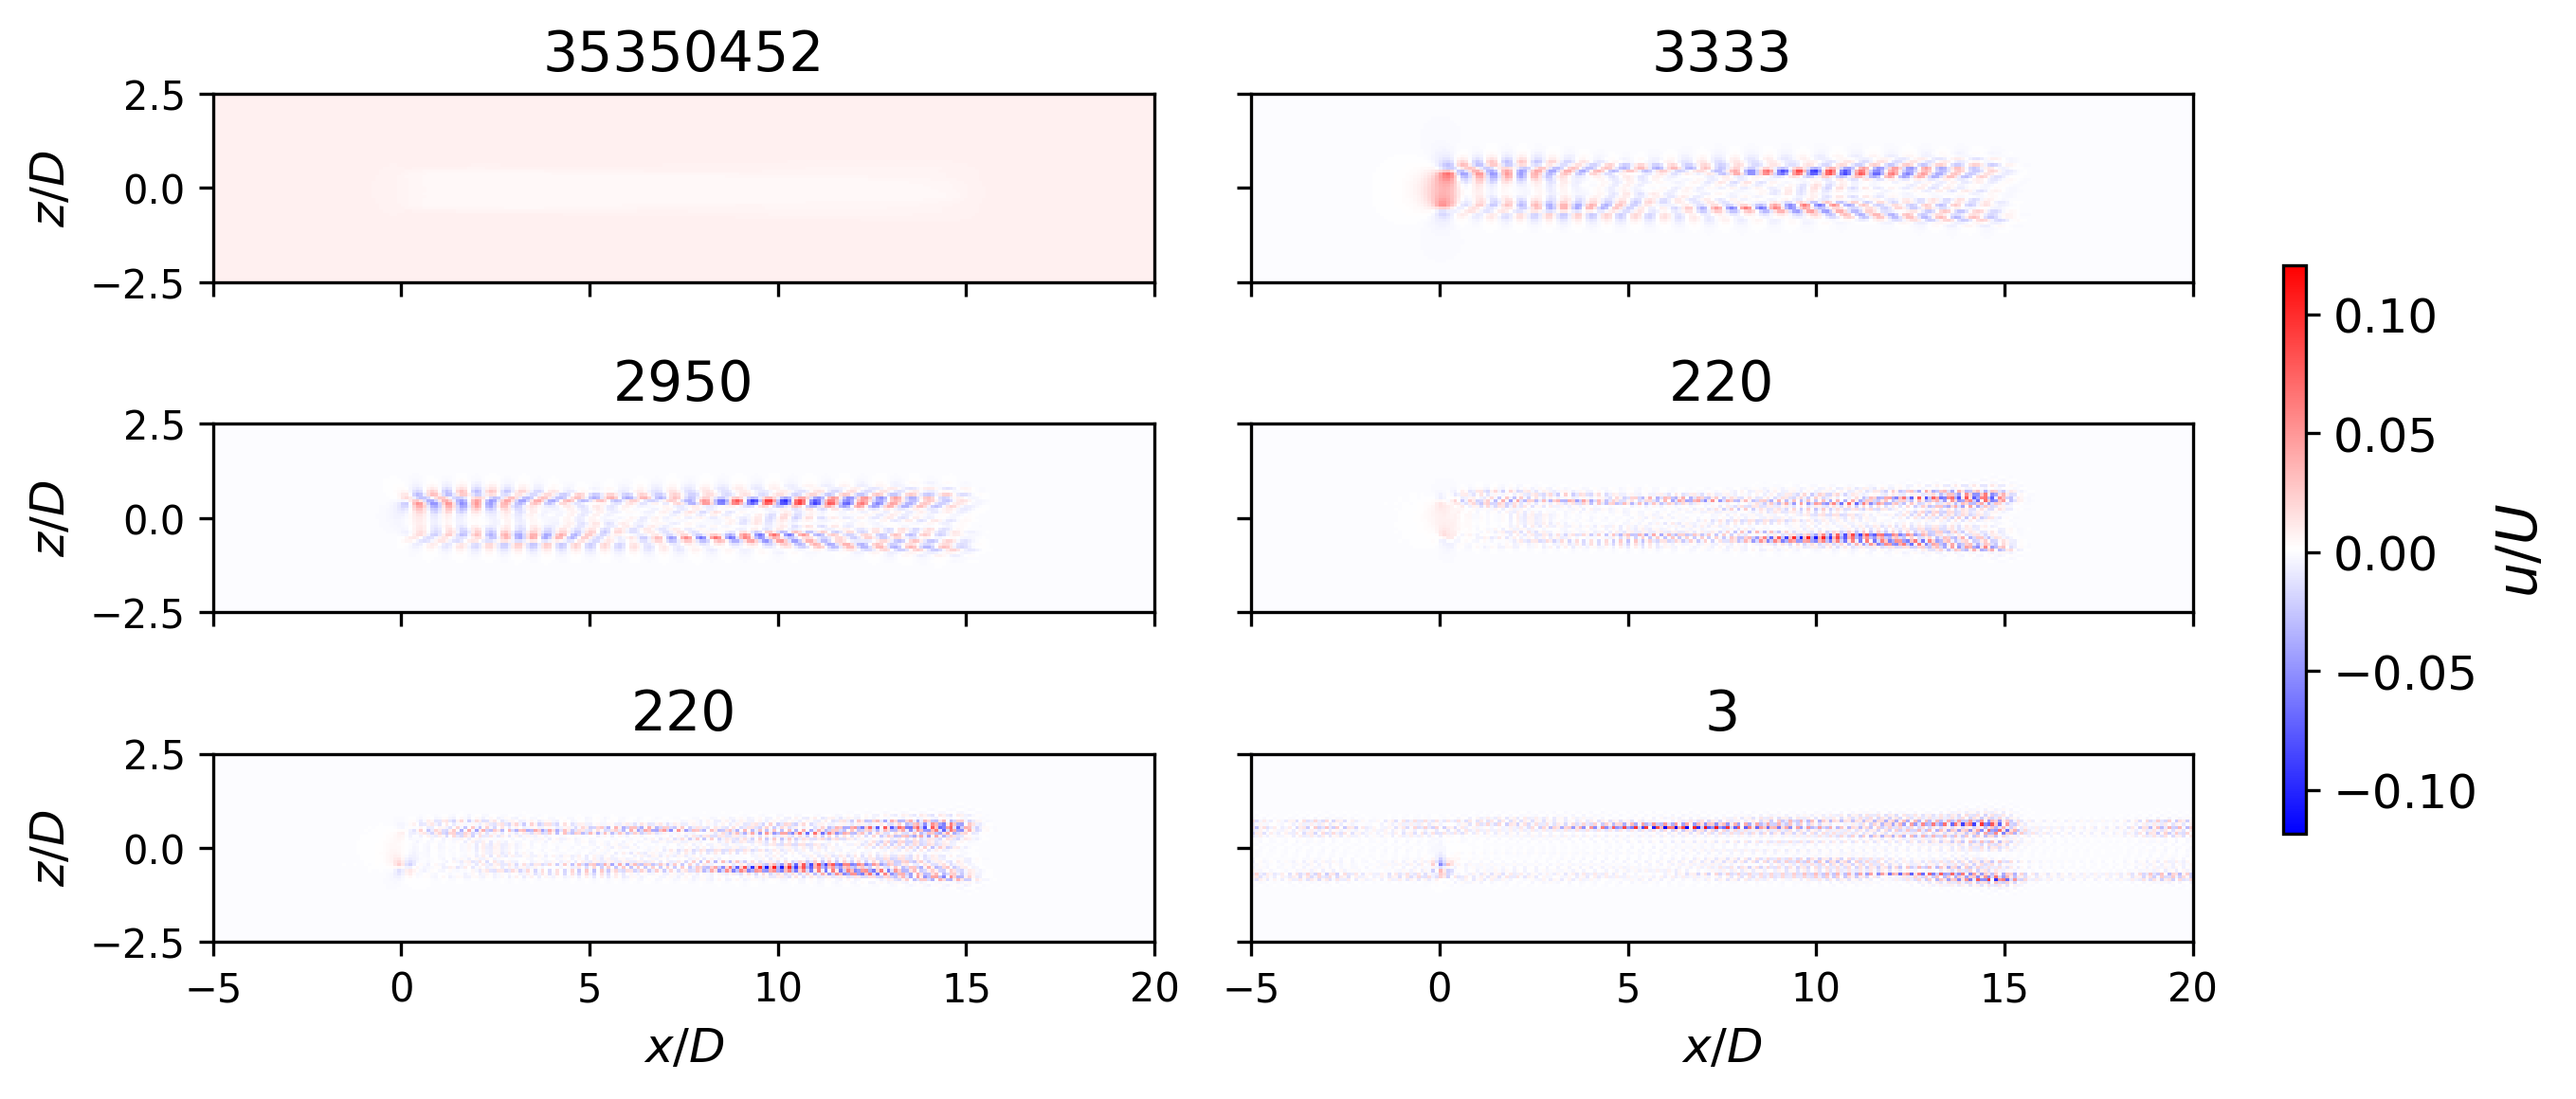

In [ ]:
modes, eigenvals = get_u_pod_modes(surging_pitching_ds, 6)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_37498/880678737.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


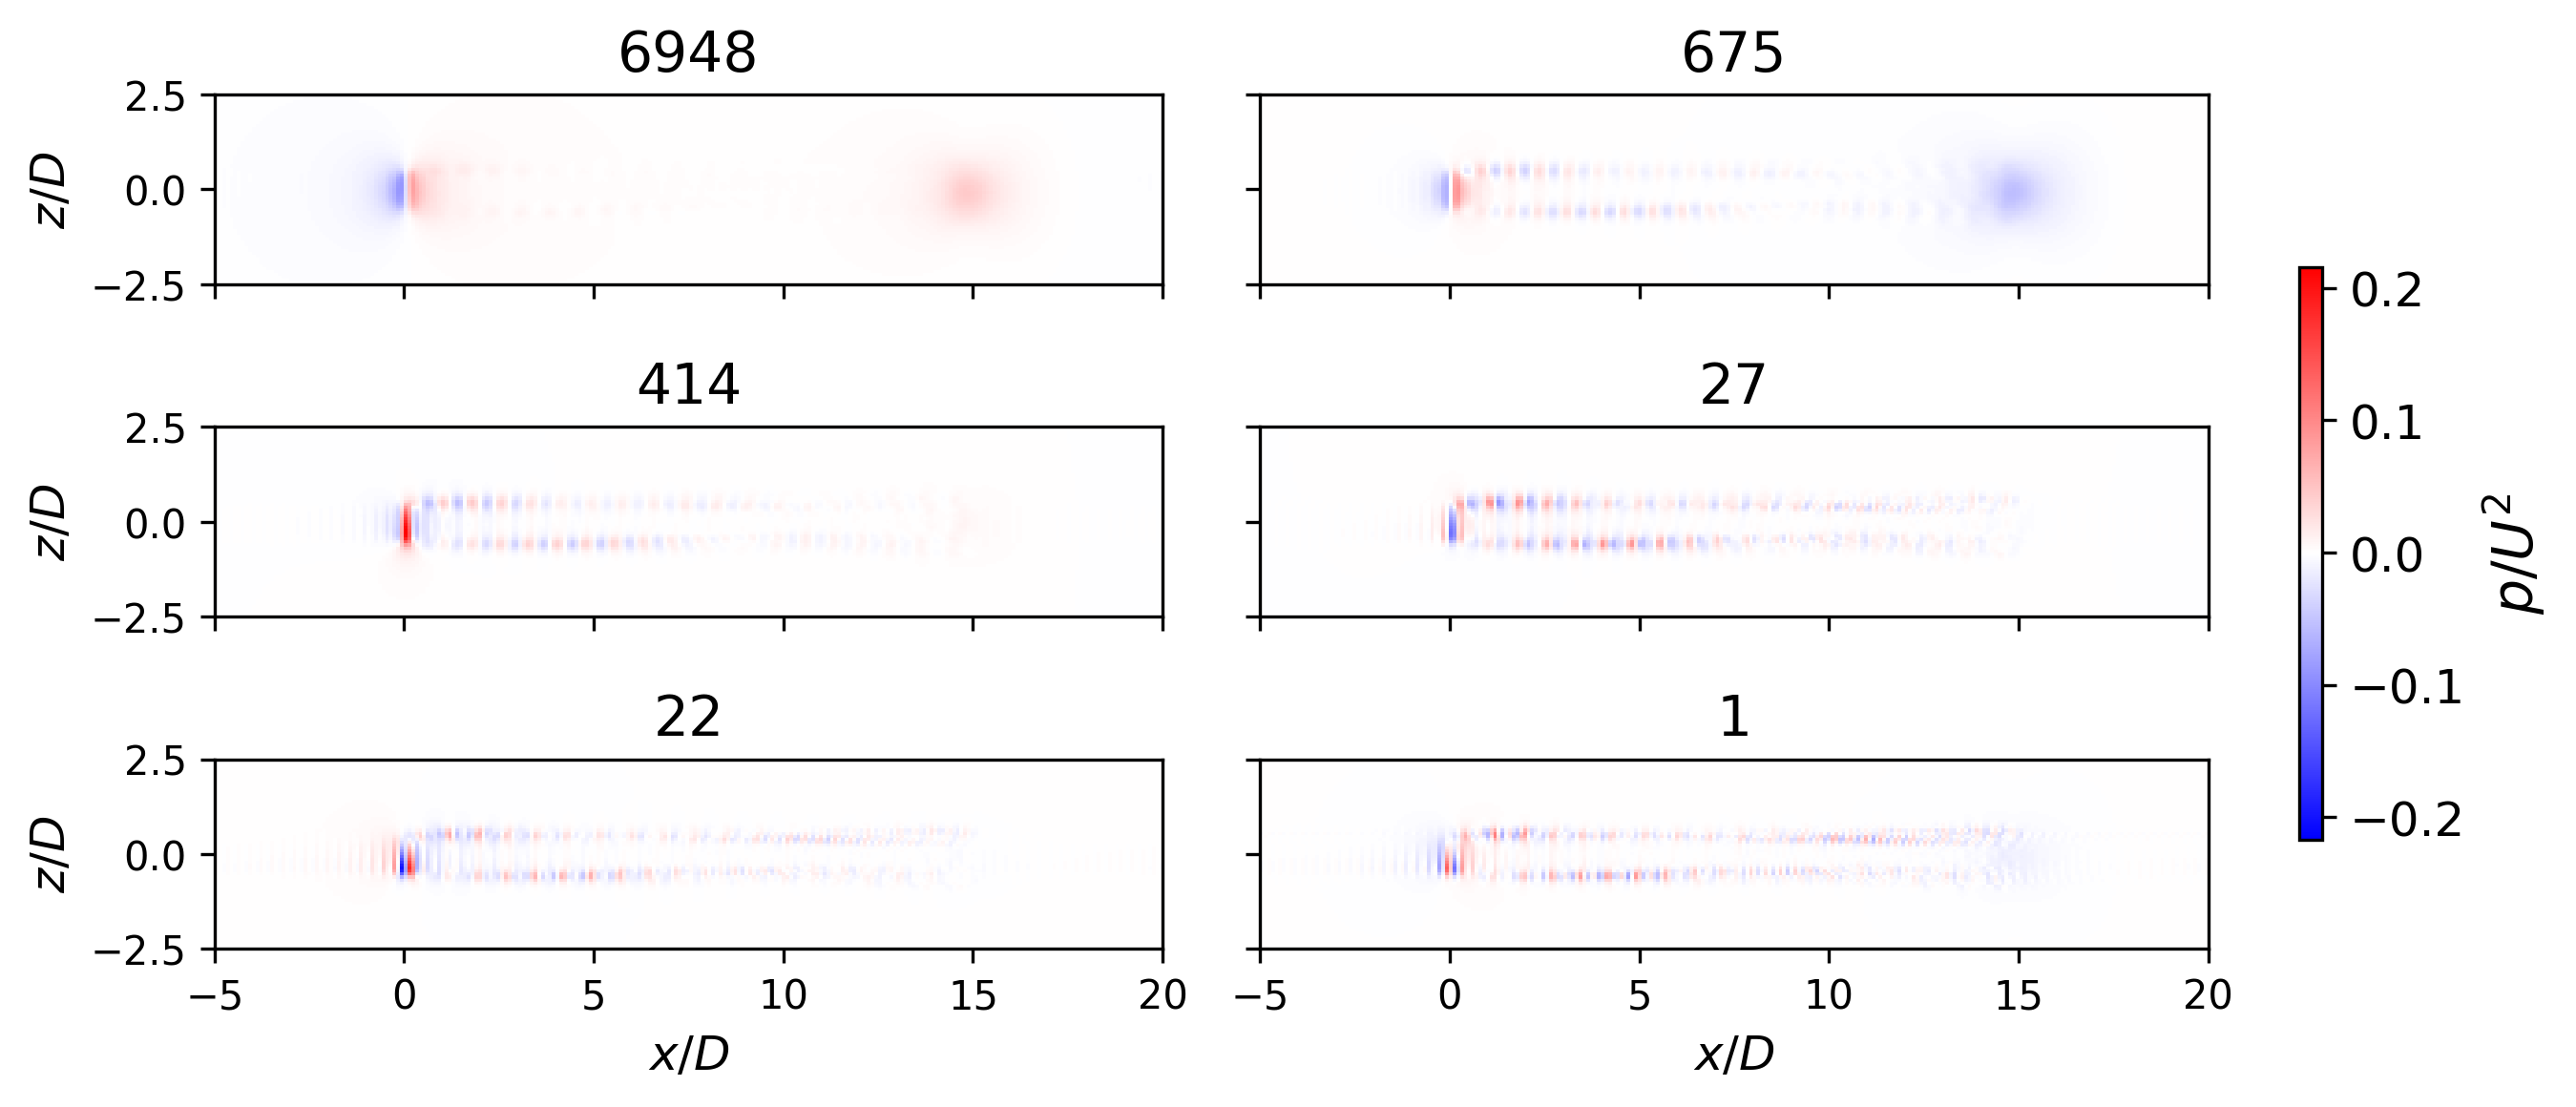

In [ ]:
modes, eigenvals = get_p_pod_modes(surging_pitching_ds, 6)